In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from FindCorrespondPts import findCorrespondPts
from segmentation import robotSegment, ransacCurveFit
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook
from utils import imshow, imshow2

In [2]:
# Loading parameters
imgl_pts = np.load('./calibration/blob_loc_left.npy')
imgr_pts = np.load('./calibration/blob_loc_right.npy')
coeff_left = np.load('./calibration/calibration_coeff_left.npy').item()
kl = coeff_left['intr_mat']

coeff_right = np.load('./calibration/calibration_coeff_right.npy').item()
kr = coeff_right['intr_mat']

trian_param = np.load('./calibration/triangulate_coeff.npy').item()

F = trian_param['F']
# 2 possible solutions for Rotation and Translation
R1 = trian_param['R1']
R2 = trian_param['R2']
T1 = trian_param['T1']
T2 = trian_param['T2']

# 4 Possible projection matrix for right camera
PR1 = np.hstack((R1, T1))
PR2 = np.hstack((R1, T2))
PR3 = np.hstack((R2, T1))
PR4 = np.hstack((R2, T2))

# Initialize Left projection matrix
PL = trian_param['PL']

PR = PR4

# Calculate template points
PR_cal = np.matmul(kr, PR)
PL_cal = np.matmul(kl, PL)

## Simple Reconstruction Shape

In [3]:
idx = 29

imgL = cv2.imread('../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
imgR = cv2.imread('../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

bg1 = cv2.imread('./segmentation/bg_res/bg_1.png')
bg2 = cv2.imread('./segmentation/bg_res/bg_2_' + str(idx//50) + '.png')

segL = robotSegment(imgL, bg2)
segR = robotSegment(imgR, bg1)

ptsR = ransacCurveFit(segR, degree = 7, trials = 100, sampleNum = 20000)
ptsL = ransacCurveFit(segL, degree = 7, trials = 100, sampleNum = 50)

ptsL_cor, ptsR_cor = findCorrespondPts(ptsL, ptsR, F, thresh = 0.01)

pts = cv2.triangulatePoints(PL_cal, PR_cal, ptsL_cor, ptsR_cor).T
pts3D = cv2.convertPointsFromHomogeneous(pts).T[:,0]

<IPython.core.display.Javascript object>


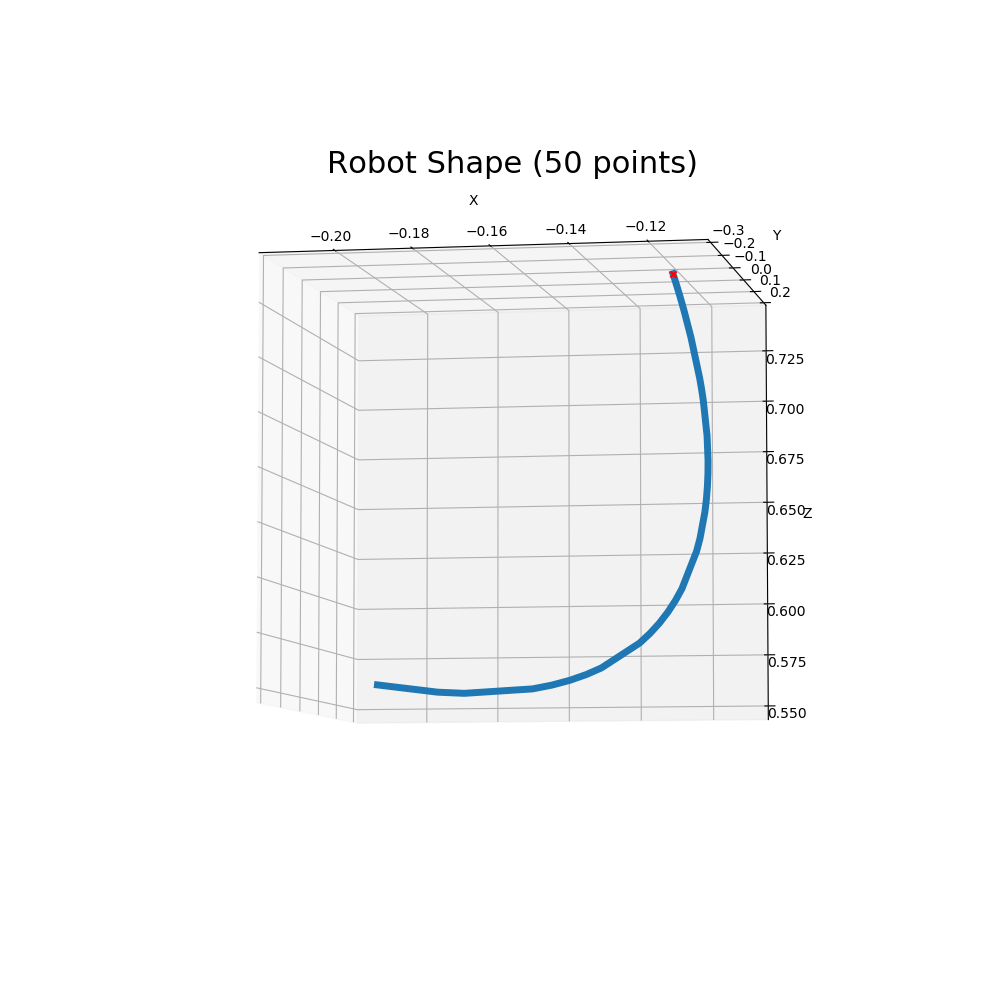

In [5]:
%matplotlib notebook
# Plot
Xs = pts3D[0]
Ys = pts3D[1]
Zs = pts3D[2]


#Ys = res3D[0]
#Zs = res3D[1]
#Xs = res3D[2]

#%matplotlib inline
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot3D(Xs, Ys, Zs, linewidth=5, label = 'Robot Shape')
#ax.scatter(Xs_tp, Ys_tp, Zs_tp)

idx = 0
ax.scatter(Xs[idx], Ys[idx], Zs[idx], c='red', marker='x', label = 'Starting Point')
#ax.scatter(Xs_tp[idx], Ys_tp[idx], Zs_tp[idx], c='blue', marker='x')

#ax.scatter(loc1[0], loc1[1], loc1[2],c='red', marker='x')
#ax.scatter(loc2[0], loc2[1], loc2[2],c='blue', marker='x')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#plt.legend(fontsize=15, loc = 3)

plt.title('Robot Shape (50 points)', fontsize = 22)
plt.show()

## Shape with More detail

In [6]:
# Load joint data points 
pt_seg_left = np.load('./segmentation/evaluation_pt_left.npy').item()
pt_seg_right = np.load('./segmentation/evaluation_pt_right_comp.npy').item()

In [7]:
eval_idx = list(pt_seg_left.keys()) + list((pt_seg_right.keys()))

In [8]:
eval_idx

[302,
 303,
 304,
 305,
 307,
 309,
 311,
 312,
 315,
 317,
 318,
 320,
 321,
 322,
 325,
 326,
 327,
 328,
 329,
 330,
 332,
 334,
 336,
 337,
 338,
 341,
 343,
 346,
 347,
 350,
 356,
 358,
 392,
 393,
 395,
 396,
 397,
 398,
 399,
 400,
 404,
 405,
 409,
 410,
 414,
 415,
 417,
 420,
 421,
 422,
 423,
 429,
 432,
 433,
 436,
 438,
 439,
 441,
 443,
 444,
 445,
 447,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 461,
 462,
 463,
 464,
 466,
 470,
 474,
 477,
 481,
 483,
 486,
 487,
 306,
 308,
 313,
 319,
 333,
 342,
 355,
 394,
 424,
 425,
 434,
 435,
 450,
 484,
 496,
 497]

In [9]:
# Obtain results for evaluation
pts3D_eval = {}
for idx in tqdm_notebook(eval_idx):
    imgL = cv2.imread('../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
    imgR = cv2.imread('../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

    bg1 = cv2.imread('./segmentation/bg_res/bg_1.png')
    bg2 = cv2.imread('./segmentation/bg_res/bg_2_' + str(idx//50) + '.png')

    segL = robotSegment(imgL, bg2)
    segR = robotSegment(imgR, bg1)

    ptsR = ransacCurveFit(segR, degree = 7, trials = 100, sampleNum = 100000)
    ptsL = ransacCurveFit(segL, degree = 7, trials = 100, sampleNum = 100)

    ptsL_cor, ptsR_cor = findCorrespondPts(ptsL, ptsR, F, thresh = 0.01)

    pts = cv2.triangulatePoints(PL_cal, PR_cal, ptsL_cor, ptsR_cor).T
    pts3D = cv2.convertPointsFromHomogeneous(pts).T[:,0]
    pts3D_eval[idx] = [ptsL_cor, ptsR_cor, pts3D]

In [10]:
pt_joint_eval = {}
for idx in tqdm_notebook(eval_idx):
    if idx in pt_seg_left:
        pt_seg = pt_seg_left
        pts_cor = pts3D_eval[idx][0]
    elif idx in pt_seg_right:
        pt_seg = pt_seg_right
        pts_cor = pts3D_eval[idx][1]
    
    # extract label joint points 
    pt1 = pt_seg[idx][0]
    pt2 = pt_seg[idx][1]
    
    # calculate most close points as joint point
    mat1 = pts_cor[0] - pt1
    dist1 = np.sqrt(np.diag(np.matmul(mat1, mat1.T)))
    jointPt1 = np.argmin(dist1)
    
    mat2 = pts_cor[0] - pt2
    dist2 = np.sqrt(np.diag(np.matmul(mat2, mat2.T)))
    jointPt2 = np.argmin(dist2)
    
    # save 2 joints for each case
    pt_joint_eval[idx] = (jointPt1, jointPt2)

In [11]:
pt_joint_eval

{302: (65, 84),
 303: (64, 72),
 304: (73, 85),
 305: (51, 71),
 307: (56, 82),
 309: (74, 91),
 311: (73, 76),
 312: (71, 89),
 315: (55, 71),
 317: (70, 75),
 318: (57, 89),
 320: (48, 73),
 321: (36, 69),
 322: (53, 88),
 325: (37, 71),
 326: (38, 73),
 327: (37, 69),
 328: (42, 68),
 329: (62, 66),
 330: (31, 61),
 332: (43, 73),
 334: (80, 83),
 336: (79, 89),
 337: (53, 81),
 338: (63, 79),
 341: (55, 85),
 343: (69, 75),
 346: (72, 80),
 347: (47, 70),
 350: (73, 96),
 356: (72, 84),
 358: (65, 87),
 392: (58, 85),
 393: (67, 90),
 395: (67, 79),
 396: (71, 99),
 397: (76, 84),
 398: (67, 71),
 399: (56, 84),
 400: (71, 86),
 404: (57, 78),
 405: (57, 83),
 409: (56, 64),
 410: (51, 79),
 414: (55, 65),
 415: (52, 74),
 417: (62, 81),
 420: (82, 86),
 421: (69, 91),
 422: (56, 87),
 423: (74, 91),
 429: (53, 85),
 432: (60, 64),
 433: (45, 76),
 436: (63, 80),
 438: (65, 86),
 439: (67, 87),
 441: (65, 83),
 443: (57, 71),
 444: (70, 97),
 445: (76, 80),
 447: (41, 71),
 451: (5

<IPython.core.display.Javascript object>


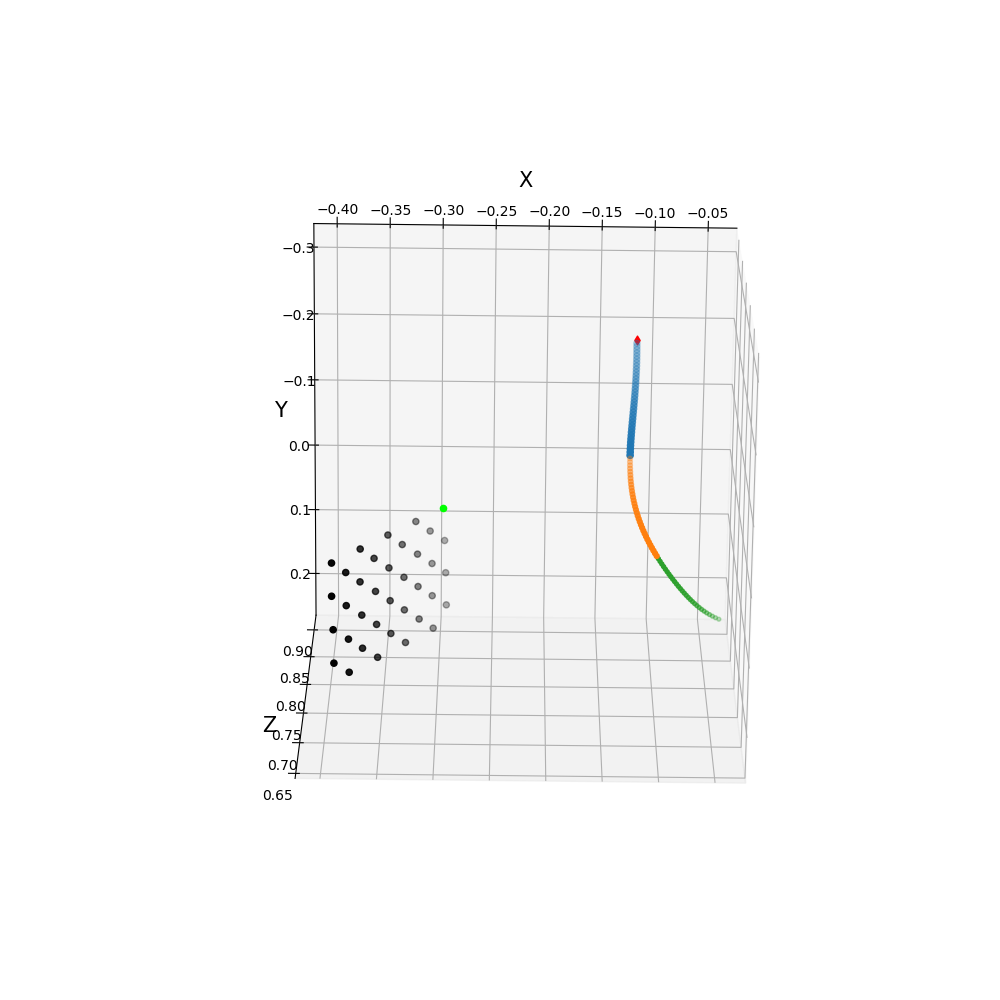

In [12]:
loc1 = np.array([[0],[0],[0]])
loc2 = np.matmul(R2, loc1 + T2)


%matplotlib notebook
idx = 321
pts3D = pts3D_eval[idx][2]
s1, s2 = pt_joint_eval[idx]

temp = cv2.triangulatePoints(PL_cal, PR_cal, imgl_pts, imgr_pts).T
temp3D = cv2.convertPointsFromHomogeneous(temp).T[:,0]

# Plot
Xs = pts3D[0]
Ys = pts3D[1]
Zs = pts3D[2]

Xs_tp = temp3D[0]
Ys_tp = temp3D[1]
Zs_tp = temp3D[2]

#%matplotlib inline
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(Xs, Ys, Zs)
ax.scatter(Xs_tp[1:], Ys_tp[1:], Zs_tp[1:], c = 'black', label = 'Template')
ax.scatter(Xs_tp[0], Ys_tp[0], Zs_tp[0], c='lime', marker='o', label = 'Right upper dot')

start = 0
jt1 = s1
jt2 = s2
end = len(pts3D[0])-1


ax.scatter(Xs[start], Ys[start], Zs[start], c='red', s=20, marker = 'd', label = 'Start Point')
# Outter Layer
ax.scatter(Xs[start+1:jt1], Ys[start+1:jt1], Zs[start+1:jt1], c='C0', s=20, label='Outer')
# Middle Layer
ax.scatter(Xs[jt1:jt2], Ys[jt1:jt2], Zs[jt1:jt2], c='C1', s=12, label='Mid')
#ax.scatter(Xs_tp[idx], Ys_tp[idx], Zs_tp[idx], c='blue', marker='x')
# Inner Layer
ax.scatter(Xs[jt2:end], Ys[jt2:end], Zs[jt2:end], c='C2', s=8, label='Inner')

#ax.scatter(loc1[0],loc1[1], loc1[2], c = 'blue')
#ax.scatter(loc2[0],loc2[1], loc2[2], c = 'red')
#ax.view_init(azim=90)
#ax.view_init(elev=-90)
#ax.legend(loc=2)


ax.set_xlabel('X',fontsize = 15)
ax.set_ylabel('Y',fontsize = 15)
ax.set_zlabel('Z',fontsize = 15)
#plt.title('Reconstructed Robot Shape')
plt.show()